# Imports

In [173]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import seaborn as sns
import seaborn.objects as so
from glob2 import glob

In [174]:
import mir_eval as me

In [175]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folde

In [176]:
cols = ['corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime']

In [177]:
def load_dataset(path):
    jsonFiles = glob(path + '/*/*.json') #Can be used absolute or relative paths 
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    for jsonFile in jsonFiles:
        # df = pd.read_json(jsonFile)
        try:
            with open(jsonFile, 'r') as f:
                data = json.loads(f.read())
        except:
            print("Error with {}".format(jsonFile))
            continue

        #lbls.append(data['groundTruth'])
        newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
        lbls = pd.concat([lbls, newLbls])

        newdf = pd.json_normalize(data, record_path = ['results'], 
            meta = ['corpus', 'piece'])
        
        #newdf['groundTruth']= data['groundTruth']
        df = pd.concat([df, newdf])
    return (df.set_index(["corpus", "piece"]),lbls.set_index(["corpus", "piece"]))

In [178]:
(results,groundTruth) = load_dataset("outputs")

Error with outputs/grieg_lyric_pieces/op38n05.json
Error with outputs/grieg_lyric_pieces/op47n01.json
Error with outputs/grieg_lyric_pieces/op47n03.json
Error with outputs/grieg_lyric_pieces/op71n03.json
Error with outputs/grieg_lyric_pieces/op68n02.json
Error with outputs/tests/shortt1.json
Error with outputs/schumann_kinderszenen/n01.json
Error with outputs/schumann_kinderszenen/n03.json


Print each parse piece

In [179]:
print(" ".join(list(results.index.levels[1].unique())))

n02op18-2_03 n04 n05 n05op18-5_02 n05op18-5_04 n09 n13 n13op130_04 n14op131_01 n14op131_03 n14op131_06 n16op135_04 op12n01 op12n02 op12n08 op38n02 op38n07 op43n01 op43n04 op47n04 op47n07 op54n02 op54n03 op54n06 op57n03 op71n07 shortest


In [180]:
results.drop(["chordLabels", "slices"],axis=1)

algorithm  accuracy    likelihood  \
corpus                piece                                                 
ABC                   n02op18-2_03     Heuristic1       NaN           NaN   
                      n02op18-2_03     Heuristic1       NaN           NaN   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
...                                           ...       ...           ...   
schumann_kinderszenen n04            RandomSample  0.000000 -9.433983e+06   
                      n04            RandomSample  0.018868 -1.320757e+07   
                      n04            RandomSample  0.018868 -1.320757e+07   
                      n04              Heuristic1  0.660377 -1.494602e+01   
                      n04           HeuristicSBS1  0.622642 -1.460816e+01   

                                     runTime  
corpus                piece                   
ABC                   n02op18-2_03       NaN  
                      n02op18-2_03       NaN  
                      n14op131_01   0.352935  
                      n14op131_01   0.138174  
                      n14op131_01   0.116186  
...                                      ...  
schumann_kinderszenen n04           0.000327  
                      n04           0.000304  
                      n04           0.000303  
                      n04           0.413173  
                      n04           0.414403  

[574 rows x 4 columns]

In [181]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

accuracy              likelihood                  runTime  \
                     mean       std          mean           std       mean   
algorithm                                                                    
Heuristic1       0.462943  0.177633 -3.491688e+06  6.711504e+06  36.053327   
HeuristicSBS1    0.477768  0.163672 -2.890704e+06  5.382276e+06  10.532710   
RandomParse      0.476304  0.165153 -3.540946e+06  6.047209e+06   0.842185   
RandomParseSBS   0.467658  0.160500 -3.403116e+06  5.791661e+06   0.051656   
RandomSample     0.014189  0.016795 -1.698797e+07  1.589520e+07   0.000202   
RandomSampleSBS  0.303060  0.125936 -2.177877e+06  3.851422e+06   0.000334   

                            
                       std  
algorithm                   
Heuristic1       74.545741  
HeuristicSBS1    16.276379  
RandomParse       1.378534  
RandomParseSBS    0.072303  
RandomSample      0.000209  
RandomSampleSBS   0.000407

In [182]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

In [183]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [184]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [185]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [186]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [188]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [193]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

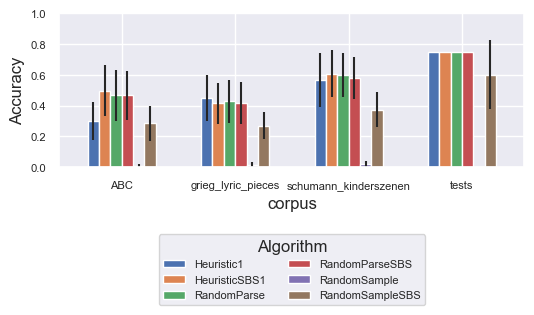

In [239]:
sns.set()  # use Seaborn styles
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

In [ ]:
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [ ]:
groundTruth.loc['ABC','n02op18-2_03']

labels    [GM, DMm7, GM, DM, DM, DMm7, DMm7, GM, Am, DMm...
Name: (ABC, n02op18-2_03), dtype: object

In [ ]:
results

algorithm  accuracy    likelihood  \
corpus                piece                                                 
ABC                   n02op18-2_03     Heuristic1       NaN           NaN   
                      n02op18-2_03     Heuristic1       NaN           NaN   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
                      n14op131_01     RandomParse  0.257485 -1.646709e+07   
...                                           ...       ...           ...   
schumann_kinderszenen n04            RandomSample  0.000000 -9.433983e+06   
                      n04            RandomSample  0.018868 -1.320757e+07   
                      n04            RandomSample  0.018868 -1.320757e+07   
                      n04              Heuristic1  0.660377 -1.494602e+01   
                      n04           HeuristicSBS1  0.622642 -1.460816e+01   

                                                                          chordLabels  \
corpus                piece                                                             
ABC                   n02op18-2_03                                               None   
                      n02op18-2_03                                               None   
                      n14op131_01   [G♯M, B♯M, C♯M, AM, G♯M, DM, G♯Mm7, F♯Mm7, C♯M...   
                      n14op131_01   [G♯M, B♯M, C♯M, AM, G♯M, DM, G♯Mm7, F♯Mm7, C♯M...   
                      n14op131_01   [G♯M, B♯M, C♯M, AM, G♯M, DM, G♯Mm7, F♯Mm7, C♯M...   
...                                                                               ...   
schumann_kinderszenen n04           [Bm, B♭M, C♯%7, B♭M, B♭M, C♯%7, A♭mm7, DM, CMm...   
                      n04           [Dm, CM, DM, C♯o7, CMm7, B♭M, DM, C♭M, GMm7, D...   
                      n04           [E♭m, B♭M, CM, BM, E♭M, FMm7, D♭Mm7, C♭M, CM, ...   
                      n04           [AMm7, C♯o7, AMm7, DM, G♯o7, AM, AMm7, C♯o7, A...   
                      n04           [AMm7, C♯o7, AMm7, DM, G♯o7, AM, AMm7, C♯o7, A...   

                                                                               slices  \
corpus                piece                                                             
ABC                   n02op18-2_03                                               None   
                      n02op18-2_03                                               None   
                      n14op131_01   [[G♯5], [B♯6], [C♯6], [A5], [G♯5], [A5, F♯5], ...   
                      n14op131_01   [[G♯5], [B♯6], [C♯6], [A5], [G♯5], [A5, F♯5], ...   
                      n14op131_01   [[G♯5], [B♯6], [C♯6], [A5], [G♯5], [A5, F♯5], ...   
...                                                                               ...   
schumann_kinderszenen n04           [[D3, B7, B7, C♯11, F♯9], [C♭-11, B♭-4, A4], [...   
                      n04           [[D3, D3, C0, F-2], [A♭-7, E6, B7, C0, G1], [D...   
                      n04           [[G♭-10, B♭-4, E♭-5], [G♭-10, F♯9, F-2, F-2, F...   
                      n04           [[E5, B5, A4, A4, G6, G5], [C♯5, C♯5, B♭5, F♯6...   
                      n04           [[E5, B5, A4, A4, G6, G5], [C♯5, C♯5, B♭5, F♯6...   

                                     runTime  
corpus                piece                   
ABC                   n02op18-2_03       NaN  
                      n02op18-2_03       NaN  
                      n14op131_01   0.352935  
                      n14op131_01   0.138174  
                      n14op131_01   0.116186  
...                                      ...  
schumann_kinderszenen n04           0.000327  
                      n04           0.000304  
                      n04           0.000303  
                      n04           0.413173  
                      n04           0.414403  

[574 rows x 6 columns]

In [ ]:
ex = results.loc['schumann_kinderszenen','n04']

/var/folders/zq/32m4qp9s339211sg4wxlr7dr0000gn/T/ipykernel_29897/50012337.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ex = results.loc['schumann_kinderszenen','n04']


In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]

algorithm  accuracy    likelihood   runTime
corpus                piece                                                   
schumann_kinderszenen n04        RandomParse  0.660377 -1.494140e+01  0.004168
                      n04        RandomParse  0.660377 -1.493340e+01  0.001612
                      n04        RandomParse  0.660377 -1.493801e+01  0.001478
                      n04        RandomParse  0.660377 -1.494140e+01  0.003723
                      n04        RandomParse  0.660377 -1.494145e+01  0.001646
                      n04     RandomParseSBS  0.584906 -1.434172e+01  0.016878
                      n04     RandomParseSBS  0.622642 -1.444055e+01  0.014206
                      n04     RandomParseSBS  0.584906 -1.430832e+01  0.017524
                      n04     RandomParseSBS  0.566038 -1.418231e+01  0.015672
                      n04     RandomParseSBS  0.547170 -1.442265e+01  0.016779
                      n04    RandomSampleSBS  0.320755 -1.432721e+01  0.000364
                      n04    RandomSampleSBS  0.301887 -1.465992e+01  0.000351
                      n04    RandomSampleSBS  0.377358 -1.427180e+01  0.000307
                      n04    RandomSampleSBS  0.396226 -1.465982e+01  0.000338
                      n04    RandomSampleSBS  0.320755 -1.415998e+01  0.000433
                      n04       RandomSample  0.037736 -1.132077e+07  0.000388
                      n04       RandomSample  0.037736 -7.547191e+06  0.000314
                      n04       RandomSample  0.000000 -9.433983e+06  0.000327
                      n04       RandomSample  0.018868 -1.320757e+07  0.000304
                      n04       RandomSample  0.018868 -1.320757e+07  0.000303
                      n04         Heuristic1  0.660377 -1.494602e+01  0.413173
                      n04      HeuristicSBS1  0.622642 -1.460816e+01  0.414403